In [121]:
import requests
import matplotlib.pyplot as plt
import numpy as np
from OSMPythonTools.overpass import overpassQueryBuilder, Overpass
from geopy import distance

In [122]:

def get_street_points(street_name,bbox):
    overpass = Overpass()
    query = overpassQueryBuilder(bbox=bbox,
    elementType='way',selector=f'"name"="{street_name}"')

    road_points = []
    for e in overpass.query(query).elements():
        for node in e.nodes():
            road_points.append((node.lon(), node.lat()))

    # points = enrich_with_elevation(road_points)
    return road_points

            

In [123]:
SHEFFIELD_BBOX = [53.356987, -1.510101, 53.402656, -1.433196]
road_points = get_street_points("Abney Street", SHEFFIELD_BBOX)


In [124]:
def middle(points):
    return (max(points) + min(points)) / 2


In [125]:
SIM_SIZE = 200

lats = [x for x,_ in road_points] #geo x's
lons = [y for _,y in road_points] #geo y's

geo_center = np.array((middle(lats),middle(lons)))

sim_points = []

for geo_point in road_points:
    geo_point = np.array(geo_point)

    relative_to_geo_center = geo_point-geo_center
    dist = distance.distance(geo_center, geo_point).m
    theta = distance.atan2(relative_to_geo_center[1], relative_to_geo_center[0])

    sim_x = dist * np.cos(theta)
    sim_y = dist * np.sin(theta)
    
    sim_x += SIM_SIZE/2
    sim_y += SIM_SIZE/2

    sim_points.append((sim_x, sim_y))

[(53.3814205, -1.4784155), (53.3817521, -1.4785487), (53.382233, -1.4787933), (53.3822937, -1.4787759), (53.3823872, -1.4782276), (53.3824258, -1.4780016)]


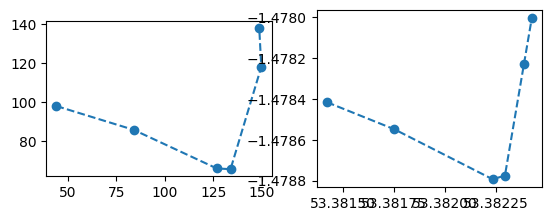

In [126]:
# print(sim_points)
fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax.set_aspect('equal', adjustable='box')
ax.ticklabel_format(useOffset=False, style='plain')
xs = [x for x,y in sim_points]
ys = [y for x,y in sim_points]
ax.plot(xs, ys, '--o')

ax = fig.add_subplot(1, 2, 2)
ax.set_aspect('equal', adjustable='box')
ax.ticklabel_format(useOffset=False, style='plain')
xs = [x for x,y in road_points]
ys = [y for x,y in road_points]
ax.plot(xs, ys, '--o')

print(road_points)

In [127]:
def _geo_to_simulation_points(self, geo_points):

    lats = [x for x,_ in geo_points] #geo x's
    lons = [y for _,y in geo_points] #geo y's
    geo_center = np.array((self.middle(lats),self.middle(lons)))

    sim_points = []

    for geo_point in geo_points:
        geo_point = np.array(geo_point)

        relative_to_geo_center = geo_point-geo_center
        dist = distance.distance(geo_center, geo_point).m
        theta = distance.atan2(relative_to_geo_center[1], relative_to_geo_center[0])

        sim_x = dist * np.cos(theta)
        sim_y = dist * np.sin(theta)
        
        sim_x += self.map_size/2
        sim_y += self.map_size/2

        sim_points.append((sim_x, sim_y))

    return sim_points